# Imports

In [9]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [10]:
import torch
import matplotlib.pyplot as plt

In [11]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (15, 5)

In [12]:
import pandas as pd
pd.options.display.max_columns = None

In [13]:
%run ../utils/__init__.py
config_logging(logging.INFO)

# Load model

In [14]:
%run ../models/checkpoint/__init__.py

In [1]:
# kwargs = {
#     'run_name': '0317_180952_vinbig_densenet-121-v2_hint-1_gmax_normD_size200_lr0.0001_sch-roc_auc-p3-f0.1',
#     'debug': True,
#     'task': 'det',
# }

# kwargs = {
#     'run_name': '0317_110119_vinbig_densenet-121-v2_drop0.3_normD_wd0.001_size256_lr0.0001_sch-roc_auc-p3-f0.1',
#     'debug': False,
#     'task': 'cls',
# }

kwargs = {
    'run_name': '0318_154252_vinbig_densenet-121-v2_drop0.3_normD_wd0.001_size256_lr0.0001_sch-roc_auc-p2-f0.1',
    'debug': False,
}

In [15]:
compiled_model = load_compiled_model_classification(**kwargs)
compiled_model.model.eval()
compiled_model.metadata['model_kwargs']

INFO(03-19 16:04) Creating CNN: densenet-121-v2, imagenet=True freeze=False gpool=avg fc_layers=[] dropout=0.3 n_labels=14
INFO(03-19 16:04) Creating CNN: densenet-121-v2, imagenet=True freeze=False gpool=avg fc_layers=[] dropout=0.3 n_labels=14


{'model_name': 'densenet-121-v2',
 'labels': ['Aortic enlargement',
  'Atelectasis',
  'Calcification',
  'Cardiomegaly',
  'Consolidation',
  'ILD',
  'Infiltration',
  'Lung Opacity',
  'Nodule/Mass',
  'Other lesion',
  'Pleural effusion',
  'Pleural thickening',
  'Pneumothorax',
  'Pulmonary fibrosis'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': [],
 'dropout': 0.3}

# Load data

In [16]:
%run ../datasets/__init__.py

In [19]:
dataset_kwargs = {
    'dataset_name': 'vinbig',
    'dataset_type': 'train',
    'max_samples': None,
    'masks': True,
    'image_size': (256, 256),
    'bboxes': True,
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

[__main__] INFO(03-19 16:05) Loading vinbig/train cl-dataset, bs=10 imgsize=(256, 256) version=None format=RGB n_labels=None
[__main__] INFO(03-19 16:05) Loading vinbig/train cl-dataset, bs=10 imgsize=(256, 256) version=None format=RGB n_labels=None
[__main__] INFO(03-19 16:05) 	Dataset size: 13500
[__main__] INFO(03-19 16:05) 	Dataset size: 13500


13500

# Show some examples

In [20]:
idx = 4

item = dataset[idx]
item.image_fname, item.labels, item.image.size(), item.masks.size()

('0007d316f756b3fa0baea2ff514ce945',
 array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]),
 torch.Size([3, 256, 256]),
 torch.Size([14, 256, 256]))

## Plot cxr and masks

Text(0.5, 1.0, 'Aortic enlargement')

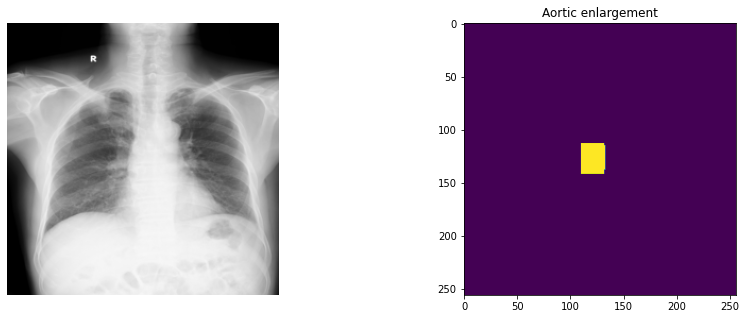

In [18]:
n_rows = 1
n_cols = 2

disease_idx = 0

plt.subplot(n_rows, n_cols, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(n_rows, n_cols, 2)
plt.imshow(item.masks[disease_idx])
plt.title(dataset.labels[disease_idx])

## Plot predictions

In [22]:
from matplotlib.patches import Rectangle

In [23]:
%run ../training/classification/grad_cam.py

In [78]:
%run ../utils/shapes.py

In [25]:
N_DISEASES = len(dataset.labels)

In [26]:
grad_cam = create_grad_cam(compiled_model.model, device='cuda')
grad_cam

In [31]:
def predict_sample(item):
    images = item.image.unsqueeze(0).cuda()
    
    with torch.no_grad():
        output = compiled_model.model(images)
        pred = output[0].squeeze(0)
        pred = torch.sigmoid(pred).cpu()

    with torch.set_grad_enabled(True):
        images.requires_grad = True
        heatmaps = calculate_attributions_for_labels(
            grad_cam, images, N_DISEASES, relu=True, create_graph=False,
        ).detach().squeeze(0).cpu()

    images.requires_grad = False

    return pred, heatmaps

In [69]:
def pred_and_label_to_valoration(presence, gt):
    if presence + gt == 2:
        result = 'TP'
    elif presence + gt == 0:
        result = 'TN'
    elif presence == 1:
        result = 'FP'
    else:
        result = 'FN'
    return result

In [70]:
def print_predictions(pred_labels, gt_labels, cls_thresh=0.3):
    print('Predictions: ')
    for score, disease, gt in zip(pred_labels, dataset.labels, gt_labels):
        presence = int(score > cls_thresh)
        result = pred_and_label_to_valoration(presence, gt)
        print(f'\t{disease:<20} = {score:.2f} (pred={presence}) | gt={gt} | value={result}')

In [81]:
def plot_sample(item, preds, heatmaps,
                cls_thresh=0.3, heat_thresh=0.5,
                only=None,
               ):
    if only:
        if isinstance(only, str):
            only = (only,)

        n_targets = sum(
            1
            for score, gt in zip(preds, item.labels)
            if pred_and_label_to_valoration(score > cls_thresh, gt) in only
        )

        if n_targets == 0:
            print(f'No predictions with valorations {only}')
            return
    else:
        n_targets = N_DISEASES
    
    n_cols = 3
    n_rows = n_targets

    plt.figure(figsize=(n_cols * 5, n_rows * 5))
    plot_row_idx = 0
    # palette_colors = plt.cm.get_cmap('jet', N_DISEASES)

    bboxes_by_disease_id = defaultdict(list)
    for bbox in item.bboxes:
        bbox_disease_id = bbox[0]
        bboxes_by_disease_id[bbox_disease_id].append(bbox[1:])
    
    plotable_image = tensor_to_range01(item.image).permute(1, 2, 0)

    for disease_idx in range(len(dataset.labels)):
        disease_name = dataset.labels[disease_idx]
        gt = item.labels[disease_idx]
        score = preds[disease_idx]
        pred = score > cls_thresh
        valoration = pred_and_label_to_valoration(pred, gt)
        
        if only is not None and valoration not in only:
            continue
        
        # Plot image with GT bboxes
        plt.subplot(n_rows, n_cols, plot_row_idx + 1)
        plt.title(f'{disease_name} (GT={gt})')
        plt.imshow(plotable_image)
        plt.axis('off')
        
        for bbox in bboxes_by_disease_id[disease_idx]:
            xmin, ymin, xmax, ymax = bbox
            height = ymax - ymin
            width = xmax - xmin
            rect = Rectangle((xmin, ymin), width, height,
                             fill=False, linewidth=2,
                             edgecolor='green')
            ax = plt.gca()
            ax.add_patch(rect)
        
        # Plot heatmap
        plt.subplot(n_rows, n_cols, plot_row_idx + 2)
        heatmap = heatmaps[disease_idx] # shape: height, width
        plt.title(f'score={score:.2f} pred={pred} ({valoration})')
        plt.imshow(heatmap)
        plt.axis('off')
        plt.colorbar()
        

        # Plot image with pred bboxes
        plt.subplot(n_rows, n_cols, plot_row_idx + 3)
        plt.imshow(plotable_image)
        title = 'BB from heatmap'
        plt.axis('off')

        bb = heatmap_to_bb(heatmap, heat_thresh)
        if bb is not None:
            xmin, ymin, xmax, ymax = bb
            height = ymax - ymin
            width = xmax - xmin
            rect = Rectangle((xmin, ymin), width, height,
                             fill=False, linewidth=2,
                             edgecolor='red')
            ax = plt.gca()
            ax.add_patch(rect)
            
            # Calculate IoU with GT
            gt_bboxes = bboxes_by_disease_id[disease_idx]
            if len(gt_bboxes) > 0:
                best_iou = max(
                    calc_iou(bb, gt_bb)
                    for gt_bb in gt_bboxes
                )
                title += f' IoU={best_iou:.2f}'
            else:
                title += ' (no GT)'

        else:
            print(f'No BB could be extracted for {disease_name}')
            
        plt.title(title)    
        
        plot_row_idx += n_cols

In [35]:
CLS_THRESH = 0.3
HEATMAP_THRESH = 0.5

No BB could be found for ILD
No BB could be found for Infiltration


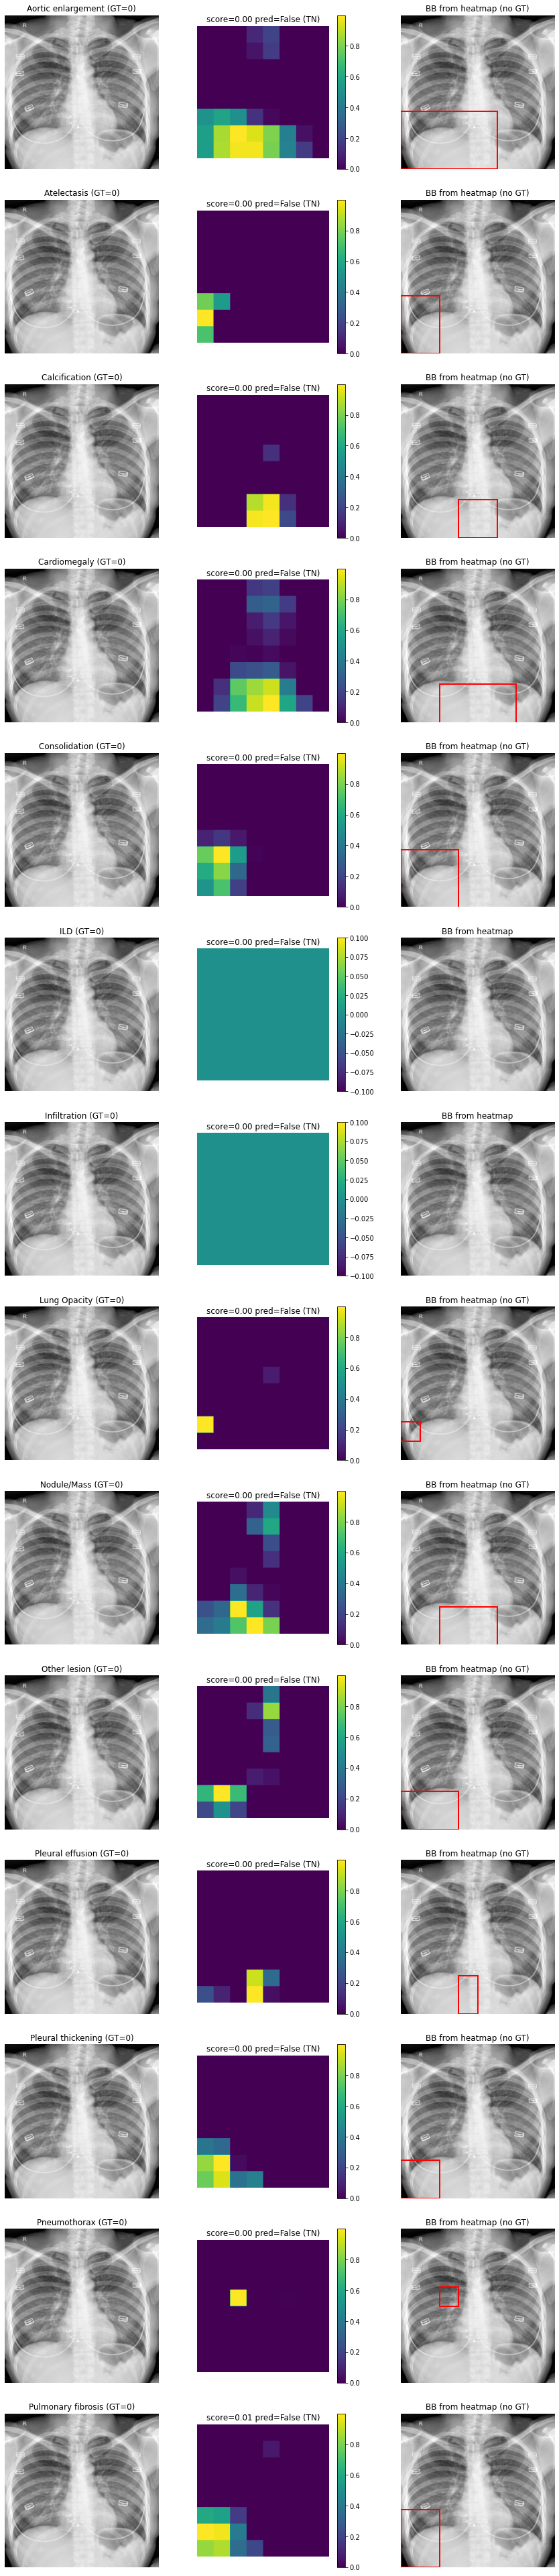

In [99]:
item = dataset[20] # 14
preds, heatmaps = predict_sample(item)
# print_predictions(preds, item.labels, cls_thresh=CLS_THRESH)
plot_sample(item, preds, heatmaps,
            cls_thresh=CLS_THRESH, heat_thresh=HEATMAP_THRESH,
            # only=('TP', 'FN'),
           )

In [65]:
item.image.size()

torch.Size([3, 256, 256])

In [66]:
heatmaps.size()

torch.Size([14, 256, 256])